## Ordinal Regression on ResMax model


In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math
import sys
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
#sys.path.insert(0,'/home/ikwak2/hmd/iy_classifier')
sys.path.insert(0,'utils')
from helper_code import *
from get_feature import *
from models import *
from Generator0 import *

In [2]:
root_dir = 'physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [3]:
import tensorflow as tf

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Jul 13 13:54:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   36C    P0    39W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [5]:
data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_folder = '/home/ubuntu/data/hmd/murmur/test'


In [7]:
model_folder = 'resmax1_ord'

## Modeling



In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [9]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

### get feature 함수확장: 음성피쳐 옵션들과, 추가 음성들 고려한 피쳐추출

In [10]:
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

In [164]:
params_feature = {'samp_sec': 20,
                  #### melspec, stft 피쳐 옵션들  
                  'pre_emphasis': 0,
                  'hop_length': 256,
                  'win_length':512,
                  'n_mels': 100,
                  #### cqt 피쳐 옵션들  
                  'filter_scale': 1,
                  'n_bins': 80,
                  'fmin': 10
}

In [165]:
def get_features_3lb_all_ord(data_folder, patient_files_trn, 
                          samp_sec=20, pre_emphasis = 0, hop_length=256, win_length = 512, n_mels = 100,
                          filter_scale = 1, n_bins = 80, fmin = 10
                         ) :
    features = dict()
    features['id'] = []
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    features['cqt1'] = []
    features['stft1'] = []
    features['raw1'] = []
#    labels = []
    mm_labels = []
    out_labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in range(num_patient_files):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            # Extract melspec
            mel1 = feature_extract_melspec(filename, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                           win_length = win_length, n_mels = n_mels)[0]
            features['mel1'].append(mel1)
            mel2 = feature_extract_cqt(filename, samp_sec=samp_sec, pre_emphasis = pre_emphasis, filter_scale = filter_scale, 
                                        n_bins = n_bins, fmin = fmin)[0]
            features['cqt1'].append(mel2)
            mel3 = feature_extract_stft(filename, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                       win_length = win_length)[0]
            features['stft1'].append(mel3)

            frequency1, recording1 = sp.io.wavfile.read(filename)
            features['raw1'].append(recording1)
            
            # Extract age_group
            age_group = get_age(current_patient_data)
            current_age_group = np.zeros(6, dtype=int)
            if age_group in age_classes:
                j = age_classes.index(age_group)
                current_age_group[j] = 1
            else :
                current_age_group[5] = 1
            features['age'].append(current_age_group)

            # Extract sex
            sex = get_sex(current_patient_data)
            sex_features = np.zeros(2, dtype=int)
            if compare_strings(sex, 'Female'):
                sex_features[0] = 1
            elif compare_strings(sex, 'Male'):
                sex_features[1] = 1
            features['sex'].append(sex_features)

            # Extract height and weight.
            height = get_height(current_patient_data)
            weight = get_weight(current_patient_data)
            ## simple impute
            if math.isnan(height) :
                height = 110.846
            if math.isnan(weight) :
                weight = 23.767
                
            features['hw'].append(np.array([height, weight]))

            # Extract pregnancy
            is_pregnant = get_pregnancy_status(current_patient_data)
            features['preg'].append(is_pregnant)

            # Extract location
            locations = entries[0]
            num_recording_locations = len(recording_locations)
            loc_features = np.zeros(num_recording_locations)
            if locations in recording_locations:
                j = recording_locations.index(locations)
                loc_features[j] = 1
            features['loc'].append(loc_features)

            # Extract labels 
            mm_label = get_murmur(current_patient_data)
            out_label = get_outcome(current_patient_data)
            if mm_label == 'Absent' :
                current_mm_labels = np.array([0, 1])
            elif mm_label == 'unknown' :
                current_mm_labels = np.array([0.31, 0.69])
            else :
                mm_loc = get_murmur_loc(current_patient_data)
                if mm_loc == 'nan' :
                    current_mm_labels = np.array([0.9, 0.1])
                else :
                    mm_loc = mm_loc.split('+')
                    if locations in mm_loc :
                        current_mm_labels = np.array([1, 0])
                    else :
                        current_mm_labels = np.array([0.8, 0.2])

            if out_label == 'Normal' :
                current_out_labels = np.array([0, 1])
            else :
                current_out_labels = np.array([1, 0])
#                if mm_label == 'Absent' :
#                    current_out_labels = np.array([0.8, 0.2])
#                elif mm_label == 'unknown' :
#                    current_out_labels = np.array([0.85, 0.15])
#                else :
#                    current_out_labels = np.array([1, 0])
                
            mm_labels.append(current_mm_labels)
            out_labels.append(current_out_labels)

    M, N = features['mel1'][i].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)
    print("melspec: ", M,N)
    mel_input_shape = (M,N,1)
        
    M, N = features['cqt1'][i].shape
    for i in range(len(features['cqt1'])) :
        features['cqt1'][i] = features['cqt1'][i].reshape(M,N,1)
    print("cqt: ", M,N)
    cqt_input_shape = (M,N,1)

    M, N = features['stft1'][i].shape
    for i in range(len(features['stft1'])) :
        features['stft1'][i] = features['stft1'][i].reshape(M,N,1)
    print("stft: ", M,N)
    stft_input_shape = (M,N,1)
        
    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
    
    mm_labels = np.array(mm_labels)
    out_labels = np.array(out_labels)
    return features, mm_labels, out_labels, mel_input_shape, cqt_input_shape, stft_input_shape


In [166]:
features_trn, mm_lbs_trn, out_lbs_trn, mel_input_shape, cqt_input_shape, stft_input_shape = get_features_3lb_all_ord(train_folder, patient_files_trn, **params_feature)
features_test, mm_lbs_test, out_lbs_test, _, _, _ = get_features_3lb_all_ord(test_folder, patient_files_test, **params_feature)

melspec:  100 313
cqt:  80 157
stft:  257 313


/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/ipykernel/__main__.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


melspec:  100 313
cqt:  80 157
stft:  257 313


### ResNet


In [234]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, maximum, DepthwiseConv2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Convolution2D, GlobalAveragePooling2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import add,concatenate
from tensorflow.keras.activations import relu, softmax, swish

def SubSpectralNorm(S, A = True, eps=1e-5):
    # S : number of sub-bands
    # A : 'Sub' Transform type if True, 
    #     'All' Transform type if False.          <- cannot be implemented yet.
    # Can be applied only for image inputs.
    
    
    def f(x):
        if S == 1:
            y = BatchNormalization()(x)
            
        else:
            F = x.shape[1]             # number of frequencies of the input.
            if F % S == 0:
                Q = F // S             # length of each sub-band.
                subs = []
                for i in range(S):     
                    subs.append(x[:, i*Q:(i+1)*Q, :,:])
                    
                for i in range(S):
                    subs[i] = BatchNormalization()(subs[i])
                    
            else:
                Q = F // S
                subs = []
                for i in range(S-1):
                    subs.append(x[:,i*Q:(i+1)*Q,:,:])
                    
                subs.append(x[:,(S-1)*Q:,:,:])      # the shape of x and y must be the same.
                
                for i in range(S):
                    subs[i] = BatchNormalization()(subs[i])
                    
            
            y = tf.concat(subs, axis=1)
            
        return y
    
    return f


def TF_ResMax_seq(out_channels = False, strides=(1,1), dilation_rate=(1,1),
                  freq_kernel_size=(3,1), temporal_kernel_size=(1,3), dropout_rate=0.3):
    
    def f(x):
        if out_channels:
            y = Conv2D(filters=out_channels, kernel_size=(1,1), strides=strides,
                       activation=None, kernel_initializer='he_uniform')(x)
            y = BatchNormalization()(y)
            y = relu(y)
            
            z = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
                                activation=None, kernel_initializer='he_uniform')(y)
            z = SubSpectralNorm(S=2)(z)
            
        else :
            z = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
                                activation=None, kernel_initializer='he_uniform')(x)
            z = SubSpectralNorm(S=2)(z)
            
        z = relu(z)
        z = DepthwiseConv2D(kernel_size=temporal_kernel_size, strides=(1,1), padding='same',
                                activation=None, kernel_initializer='he_uniform')(z)
        z = SubSpectralNorm(S=2)(z)
            #        y = relu(y)
        z = swish(z)
            
        if out_channels:
            z = Conv2D(filters=y.shape[3], kernel_size=(1,1), strides=(1,1),
                    activation='relu', kernel_initializer='he_uniform')(z)
        else :
            z = Conv2D(filters=x.shape[3], kernel_size=(1,1), strides=(1,1),
                       activation='relu', kernel_initializer='he_uniform')(z)
                
        z = SpatialDropout2D(dropout_rate)(z)
        ############################
            
        if out_channels:
            return add([y, z])
        else:
            return add([x, z])
            
    return f


    
def BC_ResMax(out_channels = False, strides=(1,1), dilation_rate=(1,1), 
              freq_kernel_size=(3,1), temporal_kernel_size=(1,3), dropout_rate=0.1):

    def f(x):
        if out_channels:
            y = Conv2D(filters=out_channels, kernel_size=(1,1), strides=strides, 
                       activation=None, kernel_initializer='he_uniform')(x)
            y = BatchNormalization()(y)
            y = relu(y)
            
            y = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
                                 activation=None, kernel_initializer='he_uniform')(y)
#            y2 = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
#                                 activation=None, kernel_initializer='he_uniform')(y)
#            y = tf.keras.layers.maximum([y1, y2])

        else :
            y = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
                                 activation=None, kernel_initializer='he_uniform')(x)
#            y2 = DepthwiseConv2D(kernel_size=freq_kernel_size, strides=(1,1), padding='same',
#                                 activation=None, kernel_initializer='he_uniform')(x)
#            y = tf.keras.layers.maximum([y1, y2])
            
        y = SubSpectralNorm(S=2)(y)                   # Should be changed to SSN
        y = relu(y)
        ############################
        
        z = AveragePooling2D(pool_size=(y.shape[1],1))(y)
        
        ########### f1 #############
        z = DepthwiseConv2D(kernel_size=temporal_kernel_size, strides=(1,1), dilation_rate=dilation_rate,
                            padding='same', activation=None, kernel_initializer='he_uniform')(z)
        z = BatchNormalization()(z)
        z = swish(z)

        z = Conv2D(filters=y.shape[3], kernel_size=(1,1), strides=(1,1),
                   activation='relu', kernel_initializer='he_uniform')(z)
        z = SpatialDropout2D(dropout_rate)(z)                  
        ############################
        
        
        ########### BC #############
        z = UpSampling2D(size=(y.shape[1],1), interpolation='nearest')(z)
        ############################
        
        if out_channels:
            return add([y, z])
        else: 
            return add([x, y, z])
        
    return f

def ResMax(n_output, k, l, upscale=False):
    def f(x):
        conv1_1 = Conv2D(filters = n_output, kernel_size =k, strides=(1, 1), padding='same', activation=None)(x)
        conv1_2 = Conv2D(filters = n_output, kernel_size =k, strides=(1, 1), padding='same', activation=None)(x)
        h = maximum([conv1_1, conv1_2])
        if l :
            conv1_1 = Conv2D(filters = n_output, kernel_size =k, strides=(1, 1), padding='same', activation=None)(h)
            conv1_2 = Conv2D(filters = n_output, kernel_size =k, strides=(1, 1), padding='same', activation=None)(h)
            h = maximum([conv1_1, conv1_2])
        if upscale:
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            f = x
        return add([f, h])
    return f




def get_ResMax_o_1(mel_input_shape, cqt_input_shape, stft_input_shape, use_mel = True, use_cqt = True, use_stft = True, ord1 = True):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
    cqt1 = keras.Input(shape=(cqt_input_shape), name = 'cqt')
    stft1 = keras.Input(shape=(stft_input_shape), name = 'stft')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    x = ResMax(16,3,1, upscale = True)(mel1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    mel2 = GlobalAveragePooling2D()(x)
    
    ## cqt embedding
    x = ResMax(16,3,1, upscale = True)(cqt1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    cqt2 = GlobalAveragePooling2D()(x)

    ## stft embedding
    x = ResMax(16,3,1, upscale = True)(stft1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    stft2 = GlobalAveragePooling2D()(x)
    
#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
    
    if use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2, stft2])
    if not use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([cqt2, stft2])
    if use_mel and not use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, stft2])
    if use_mel and use_cqt and not use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2])
    if not use_mel and not use_cqt and use_stft :  ## stft 만
        concat2 = stft2
    if use_mel and not use_cqt and not use_stft :  ### mel만
        concat2 = mel2
    if not use_mel and use_cqt and not use_stft :  ### cqt만
        concat2 = cqt2
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    if ord1 :
        res1 = layers.Dense(2, activation = "softmax")(concat2)
    else :
        res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1,cqt1,stft1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy','AUC'])
    return(model)

def get_ResMax_2(mel_input_shape, cqt_input_shape, stft_input_shape, use_mel = True, use_cqt = True, use_stft = True):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
    cqt1 = keras.Input(shape=(cqt_input_shape), name = 'cqt')
    stft1 = keras.Input(shape=(stft_input_shape), name = 'stft')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    x = ResMax(16,3,1, upscale = True)(mel1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    mel2 = GlobalAveragePooling2D()(x)
    
    ## cqt embedding
    x = ResMax(16,3,1, upscale = True)(cqt1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    cqt2 = GlobalAveragePooling2D()(x)

    ## stft embedding
    x = ResMax(16,3,1, upscale = True)(stft1)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(16,5,1, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ResMax(24,3,1, upscale = True)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(32,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(32,3,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(48,3,0, upscale = True)(x)
    x = BatchNormalization()(x)
    x = ResMax(48,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = True)(x)
    x = BatchNormalization()(x)
#    x = Dropout(dropout_rate)(x)
    x = ResMax(64,1,0, upscale = False)(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    stft2 = GlobalAveragePooling2D()(x)
    
#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
    
    if use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2, stft2])
    if not use_mel and use_cqt and use_stft :
        concat2 = layers.Concatenate()([cqt2, stft2])
    if use_mel and not use_cqt and use_stft :
        concat2 = layers.Concatenate()([mel2, stft2])
    if use_mel and use_cqt and not use_stft :
        concat2 = layers.Concatenate()([mel2, cqt2])
    if not use_mel and not use_cqt and use_stft :  ## stft 만
        concat2 = stft2
    if use_mel and not use_cqt and not use_stft :  ### mel만
        concat2 = mel2
    if not use_mel and use_cqt and not use_stft :  ### cqt만
        concat2 = cqt2
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1,cqt1,stft1] , outputs = res2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy','AUC'])
    return(model)

In [235]:
#model1 = get_toy5_1(mel_input_shape, cqt_input_shape, stft_input_shape)
#model2 = get_toy5_2(mel_input_shape, cqt_input_shape, stft_input_shape)


In [169]:
model1 = get_ResMax_o_1(mel_input_shape, cqt_input_shape, stft_input_shape, use_mel = True, use_cqt = False, use_stft = False)
model2 = get_ResMax_2(mel_input_shape, cqt_input_shape, stft_input_shape, use_mel = True, use_cqt = False, use_stft = False)


In [170]:
model1.summary()

Model: "model_386"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_33582 (Conv2D)           (None, 100, 313, 16) 160         mel[0][0]                        
__________________________________________________________________________________________________
conv2d_33583 (Conv2D)           (None, 100, 313, 16) 160         mel[0][0]                        
__________________________________________________________________________________________________
maximum_13896 (Maximum)         (None, 100, 313, 16) 0           conv2d_33582[0][0]               
                                                                 conv2d_33583[0][0]       

In [238]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'], 
           features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
                        mm_lbs_trn,  ## our Y
                        **params)()

#ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
#           features_test[0]['mel1'],features_test[0]['cqt1'],features_test[0]['stft1']], 
#                        mm_lbs_test,  ## our Y
#                        **params_no_shuffle)()

    
model1.fit(TrainDGen_1,
          validation_data = ([features_test['age'],features_test['sex'], features_test['hw'], 
                              features_test['preg'], features_test['loc'], features_test['mel1'], 
                              features_test['cqt1'], features_test['stft1']], 
                             mm_lbs_test), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(mm_lbs_trn)/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 9s 227ms/step - loss: 0.4474 - accuracy: 0.7996 - auc: 0.9392 - val_loss: 0.4412 - val_accuracy: 0.8114 - val_auc: 0.9089
Epoch 2/100
40/40 [==============================] - 8s 204ms/step - loss: 0.4559 - accuracy: 0.7906 - auc: 0.9357 - val_loss: 0.4636 - val_accuracy: 0.7813 - val_auc: 0.8964
Epoch 3/100
40/40 [==============================] - 9s 216ms/step - loss: 0.4521 - accuracy: 0.8039 - auc: 0.9308 - val_loss: 0.4162 - val_accuracy: 0.8415 - val_auc: 0.9186
Epoch 4/100
40/40 [==============================] - 8s 214ms/step - loss: 0.4533 - accuracy: 0.7867 - auc: 0.9324 - val_loss: 0.4267 - val_accuracy: 0.8257 - val_auc: 0.9219
Epoch 5/100
40/40 [==============================] - 8s 204ms/step - loss: 0.4603 - accuracy: 0.7926 - auc: 0.9328 - val_loss: 0.4107 - val_accuracy: 0.8352 - val_auc: 0.9217
Epoch 6/100
40/40 [==============================] - 8s 214ms/step - loss: 0.4662 - accuracy: 0.7891 - auc: 0.9281 - val_loss

40/40 [==============================] - 6s 158ms/step - loss: 0.4466 - accuracy: 0.7895 - auc: 0.9375 - val_loss: 0.4213 - val_accuracy: 0.8209 - val_auc: 0.9173
Epoch 48/100
40/40 [==============================] - 6s 155ms/step - loss: 0.4383 - accuracy: 0.8039 - auc: 0.9415 - val_loss: 0.4151 - val_accuracy: 0.8177 - val_auc: 0.9205
Epoch 49/100
40/40 [==============================] - 6s 155ms/step - loss: 0.4547 - accuracy: 0.7934 - auc: 0.9358 - val_loss: 0.4446 - val_accuracy: 0.8336 - val_auc: 0.9247
Epoch 50/100
40/40 [==============================] - 6s 164ms/step - loss: 0.4379 - accuracy: 0.8086 - auc: 0.9414 - val_loss: 0.4153 - val_accuracy: 0.8336 - val_auc: 0.9236
Epoch 51/100
40/40 [==============================] - 6s 163ms/step - loss: 0.4305 - accuracy: 0.8082 - auc: 0.9364 - val_loss: 0.4114 - val_accuracy: 0.8447 - val_auc: 0.9289
Epoch 52/100
40/40 [==============================] - 6s 160ms/step - loss: 0.4310 - accuracy: 0.8066 - auc: 0.9412 - val_loss: 0.411

Epoch 94/100
40/40 [==============================] - 6s 158ms/step - loss: 0.4232 - accuracy: 0.8086 - auc: 0.9486 - val_loss: 0.4114 - val_accuracy: 0.8304 - val_auc: 0.9241
Epoch 95/100
40/40 [==============================] - 6s 163ms/step - loss: 0.4159 - accuracy: 0.8086 - auc: 0.9479 - val_loss: 0.4112 - val_accuracy: 0.8320 - val_auc: 0.9241
Epoch 96/100
40/40 [==============================] - 6s 158ms/step - loss: 0.4270 - accuracy: 0.8082 - auc: 0.9475 - val_loss: 0.4110 - val_accuracy: 0.8320 - val_auc: 0.9243
Epoch 97/100
40/40 [==============================] - 6s 164ms/step - loss: 0.4430 - accuracy: 0.8027 - auc: 0.9419 - val_loss: 0.4109 - val_accuracy: 0.8320 - val_auc: 0.9244
Epoch 98/100
40/40 [==============================] - 6s 162ms/step - loss: 0.4253 - accuracy: 0.8066 - auc: 0.9489 - val_loss: 0.4111 - val_accuracy: 0.8304 - val_auc: 0.9245
Epoch 99/100
40/40 [==============================] - 7s 180ms/step - loss: 0.4270 - accuracy: 0.8160 - auc: 0.9448 - va

트레이닝 accuracy 와 auc 가 validation accuracy, auc 와 거의 유사함

In [239]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'], 
           features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
                        out_lbs_trn,  ## our Y
                        **params)()

#ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
#           features_test[0]['mel1'],features_test[0]['cqt1'],features_test[0]['stft1']], 
#                        features_test[2],  ## our Y
#                        **params_no_shuffle)()

    
model2.fit(TrainDGen_1,
          validation_data = ([features_test['age'],features_test['sex'], features_test['hw'], 
                              features_test['preg'], features_test['loc'], features_test['mel1'], 
                              features_test['cqt1'], features_test['stft1']], 
                             out_lbs_test), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(out_lbs_trn)/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 8s 196ms/step - loss: 0.6564 - accuracy: 0.6219 - auc: 0.6983 - val_loss: 0.6723 - val_accuracy: 0.6101 - val_auc: 0.6628
Epoch 2/100
40/40 [==============================] - 7s 178ms/step - loss: 0.6705 - accuracy: 0.6109 - auc: 0.6868 - val_loss: 0.6448 - val_accuracy: 0.6498 - val_auc: 0.6819
Epoch 3/100
40/40 [==============================] - 7s 177ms/step - loss: 0.6589 - accuracy: 0.6078 - auc: 0.6984 - val_loss: 0.8001 - val_accuracy: 0.5293 - val_auc: 0.5461
Epoch 4/100
40/40 [==============================] - 7s 175ms/step - loss: 0.6636 - accuracy: 0.6062 - auc: 0.6840 - val_loss: 0.6491 - val_accuracy: 0.6355 - val_auc: 0.6828
Epoch 5/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6591 - accuracy: 0.6121 - auc: 0.6976 - val_loss: 0.7067 - val_accuracy: 0.5404 - val_auc: 0.5733
Epoch 6/100
40/40 [==============================] - 7s 174ms/step - loss: 0.6621 - accuracy: 0.6117 - auc: 0.6985 - val_loss

40/40 [==============================] - 7s 177ms/step - loss: 0.6343 - accuracy: 0.6574 - auc: 0.7612 - val_loss: 0.6584 - val_accuracy: 0.6339 - val_auc: 0.6648
Epoch 48/100
40/40 [==============================] - 7s 184ms/step - loss: 0.6380 - accuracy: 0.6539 - auc: 0.7608 - val_loss: 0.6601 - val_accuracy: 0.5784 - val_auc: 0.6458
Epoch 49/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6288 - accuracy: 0.6617 - auc: 0.7686 - val_loss: 0.6663 - val_accuracy: 0.6260 - val_auc: 0.6602
Epoch 50/100
40/40 [==============================] - 7s 186ms/step - loss: 0.6312 - accuracy: 0.6445 - auc: 0.7643 - val_loss: 0.6535 - val_accuracy: 0.6212 - val_auc: 0.6692
Epoch 51/100
40/40 [==============================] - 7s 167ms/step - loss: 0.6258 - accuracy: 0.6668 - auc: 0.7731 - val_loss: 0.6667 - val_accuracy: 0.6339 - val_auc: 0.6723
Epoch 52/100
40/40 [==============================] - 7s 173ms/step - loss: 0.6251 - accuracy: 0.6676 - auc: 0.7650 - val_loss: 0.664

Epoch 94/100
40/40 [==============================] - 7s 171ms/step - loss: 0.5987 - accuracy: 0.7066 - auc: 0.8201 - val_loss: 0.6571 - val_accuracy: 0.6244 - val_auc: 0.6709
Epoch 95/100
40/40 [==============================] - 7s 168ms/step - loss: 0.6129 - accuracy: 0.6938 - auc: 0.8065 - val_loss: 0.6582 - val_accuracy: 0.6244 - val_auc: 0.6698
Epoch 96/100
40/40 [==============================] - 7s 180ms/step - loss: 0.6114 - accuracy: 0.6918 - auc: 0.8023 - val_loss: 0.6598 - val_accuracy: 0.6260 - val_auc: 0.6677
Epoch 97/100
40/40 [==============================] - 7s 172ms/step - loss: 0.6079 - accuracy: 0.6855 - auc: 0.8091 - val_loss: 0.6605 - val_accuracy: 0.6292 - val_auc: 0.6665
Epoch 98/100
40/40 [==============================] - 7s 181ms/step - loss: 0.6124 - accuracy: 0.6777 - auc: 0.8149 - val_loss: 0.6602 - val_accuracy: 0.6228 - val_auc: 0.6674
Epoch 99/100
40/40 [==============================] - 7s 170ms/step - loss: 0.6100 - accuracy: 0.6727 - auc: 0.8075 - va

### 팀코드 수정해야 할 함수들..

In [240]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 100,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'mel_shape': (100, 313, 1),
 'cqt_shape': (80, 157, 1),
 'stft_shape': (257, 313, 1),
 'model1': 'resmax_o_1',
 'model2': 'resmax2',
 'model_fnm1': 'resmax1_ord/resmax_o_1_model1.hdf5',
 'model_fnm2': 'resmax1_ord/resmax2_model2.hdf5'}

In [241]:
params_feature['mel_shape'] = mel_input_shape
params_feature['cqt_shape'] = cqt_input_shape
params_feature['stft_shape'] = stft_input_shape


In [242]:
import pickle as pk
def save_challenge_model(model_folder, model1, model2, m_name1, m_name2, param_feature) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename1 = os.path.join(model_folder, m_name1 + '_model1.hdf5')
    filename2 = os.path.join(model_folder, m_name2 + '_model2.hdf5')
    model1.save(filename1)
    model2.save(filename2)
    param_feature['model1'] = m_name1
    param_feature['model2'] = m_name2
    param_feature['model_fnm1'] = filename1
    param_feature['model_fnm2'] = filename2

    with open(info_fnm, 'wb') as f:
        pk.dump(param_feature, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [243]:
model_folder

'resmax1_ord'

In [244]:
save_challenge_model(model_folder, model1, model2, m_name1 = 'resmax_o_1', m_name2 = 'resmax2', param_feature = params_feature)

1

In [245]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)
#    if info_m['model'] == 'toy' :
#        model = get_toy(info_m['mel_shape'])
#    filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
#    model.load_weights(filename)
    return info_m

In [246]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 100,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'mel_shape': (100, 313, 1),
 'cqt_shape': (80, 157, 1),
 'stft_shape': (257, 313, 1),
 'model1': 'resmax_o_1',
 'model2': 'resmax2',
 'model_fnm1': 'resmax1_ord/resmax_o_1_model1.hdf5',
 'model_fnm2': 'resmax1_ord/resmax2_model2.hdf5'}

In [247]:
def run_challenge_model(model, data, recordings, verbose):
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']
    
    if model['model1'] == 'toy1' :
        model1 = get_toy5_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'] )
    if model['model2'] == 'toy2' :
        model2 = get_toy5_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'])
    if model['model1'] == 'lcnn1' :
        model1 = get_LCNN_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model2'] == 'lcnn2' :
        model2 = get_LCNN_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model1'] == 'resmax1' :
        model1 = get_ResMax_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model1'] == 'resmax_o_1' :
        model1 = get_ResMax_o_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model2'] == 'resmax2' :
        model2 = get_ResMax_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model1'] == 'bcresmax1' :
        model1 = get_BCResMax_1(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    if model['model2'] == 'bcresmax2' :
        model2 = get_BCResMax_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], use_mel = True, use_cqt = False, use_stft = False)
    model1.load_weights(model['model_fnm1'])
    model2.load_weights(model['model_fnm2'])
    
#    classes = model['classes']
    # Load features.
    features = get_feature_one(data, verbose = 0)

    samp_sec = model['samp_sec'] 
    pre_emphasis = model['pre_emphasis']
    hop_length = model['hop_length']
    win_length = model['win_length']
    n_mels = model['n_mels']
    filter_scale = model['filter_scale']
    n_bins = model['n_bins']
    fmin = model['fmin']
    
    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                           win_length = win_length, n_mels = n_mels)[0]
        features['mel1'].append(mel1)
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
    features['mel1'] = np.array(features['mel1'])

    features['cqt1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_cqt(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, filter_scale = filter_scale, 
                                        n_bins = n_bins, fmin = fmin)[0]
        features['cqt1'].append(mel1)
    M, N = features['cqt1'][0].shape
    for i in range(len(features['cqt1'])) :
        features['cqt1'][i] = features['cqt1'][i].reshape(M,N,1)   
    features['cqt1'] = np.array(features['cqt1'])

    features['stft1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_stft(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                       win_length = win_length)[0]
        features['stft1'].append(mel1)
    M, N = features['stft1'][0].shape
    for i in range(len(features['stft1'])) :
        features['stft1'][i] = features['stft1'][i].reshape(M,N,1)           
    features['stft1'] = np.array(features['stft1'])

    #    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1'], features['cqt1'], features['stft1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1'], features['cqt1'], features['stft1']])

    # Get classifier probabilities.
    idx1 = res1.argmax(axis=0)[0]
    murmur_p = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기
    murmur_probabilities = np.zeros((3,))
    murmur_probabilities[0] = murmur_p[0]
    murmur_probabilities[1] = 0
    murmur_probabilities[2] = murmur_p[1]
    outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기
#    idx = np.argmax(prob1)

    ## 이부분도 생각 필요.. rule 을 cost를 maximize 하는 기준으로 threshold 탐색 필요할지도..
    # Choose label with highest probability.
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    idx = np.argmax(murmur_probabilities)
    murmur_labels[idx] = 1
    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1
    
    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))
    
    return classes, labels, probabilities

### 대회 평가용 run_model 함수 (수정 불필요)

In [248]:
# Run model.
def run_model(model_folder, data_folder, output_folder, allow_failures, verbose):
    # Load models.
    if verbose >= 1:
        print('Loading Challenge model...')

    model = load_challenge_model(model_folder, verbose) ### Teams: Implement this function!!!

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Create a folder for the Challenge outputs if it does not already exist.
    os.makedirs(output_folder, exist_ok=True)

    # Run the team's model on the Challenge data.
    if verbose >= 1:
        print('Running model on Challenge data...')

    # Iterate over the patient files.
    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        patient_data = load_patient_data(patient_files[i])
        recordings = load_recordings(data_folder, patient_data)

        # Allow or disallow the model to fail on parts of the data; helpful for debugging.
        try:
            classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!
        except:
            if allow_failures:
                if verbose >= 2:
                    print('... failed.')
                classes, labels, probabilities = list(), list(), list()
            else:
                raise

        # Save Challenge outputs.
        head, tail = os.path.split(patient_files[i])
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_folder, root + '.csv')
        patient_id = get_patient_id(patient_data)
        save_challenge_outputs(output_file, patient_id, classes, labels, probabilities)

    if verbose >= 1:
        print('Done.')

In [249]:
## 우리 모형 저장된 폴더이름
model_folder

'resmax1_ord'

In [250]:
## 테스트 데이터 폴더
test_folder

'/home/ubuntu/data/hmd/murmur/test'

In [251]:
## 테스트 데이터에 모형 돌려서 스코어 저장할 폴더
output_folder = '/home/ubuntu/hmd/notebooks/out_resmax_o_1'

In [252]:
run_model(model_folder, test_folder, output_folder, allow_failures = True, verbose = 1)

Loading Challenge model...
Running model on Challenge data...


Done.


In [253]:
data_folder = test_folder; verbose = 1

In [254]:
    model = load_challenge_model(model_folder, verbose) ### Teams: Implement this function!!!

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)


In [255]:
model

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 100,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'mel_shape': (100, 313, 1),
 'cqt_shape': (80, 157, 1),
 'stft_shape': (257, 313, 1),
 'model1': 'resmax_o_1',
 'model2': 'resmax2',
 'model_fnm1': 'resmax1_ord/resmax_o_1_model1.hdf5',
 'model_fnm2': 'resmax1_ord/resmax2_model2.hdf5'}

In [256]:
i = 0
patient_data = load_patient_data(patient_files[i])
recordings = load_recordings(data_folder, patient_data)
classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!


In [257]:
    samp_sec = model['samp_sec'] 
    pre_emphasis = model['pre_emphasis']
    hop_length = model['hop_length']
    win_length = model['win_length']
    n_mels = model['n_mels']
    filter_scale = model['filter_scale']
    n_bins = model['n_bins']
    fmin = model['fmin']


In [258]:
for i in range(len(patient_files_test)) :
    patient_data = load_patient_data(patient_files_test[i])
    recordings = load_recordings(data_folder, patient_data)
    data = patient_data

    print(patient_data)
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                           win_length = win_length, n_mels = n_mels)[0]
        features['mel1'].append(mel1)
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
    features['mel1'] = np.array(features['mel1'])

    features['cqt1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_cqt(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, filter_scale = filter_scale, 
                                        n_bins = n_bins, fmin = fmin)[0]
        features['cqt1'].append(mel1)
    M, N = features['cqt1'][0].shape
    for i in range(len(features['cqt1'])) :
        features['cqt1'][i] = features['cqt1'][i].reshape(M,N,1)   
    features['cqt1'] = np.array(features['cqt1'])

    features['stft1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_stft(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                       win_length = win_length)[0]
        features['stft1'].append(mel1)
    M, N = features['stft1'][0].shape
    for i in range(len(features['stft1'])) :
        features['stft1'][i] = features['stft1'][i].reshape(M,N,1)           
    features['stft1'] = np.array(features['stft1'])

    #    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1'], features['cqt1'], features['stft1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1'], features['cqt1'], features['stft1']])

    print("present", "unknown", "absent")
    print(res1)
    print("normal", "abnormal")
    print(res2)

33151 4 4000
AV 33151_AV.hea 33151_AV.wav 33151_AV.tsv
PV 33151_PV.hea 33151_PV.wav 33151_PV.tsv
TV 33151_TV.hea 33151_TV.wav 33151_TV.tsv
MV 33151_MV.hea 33151_MV.wav 33151_MV.tsv
#Age: Child
#Sex: Female
#Height: 141.0
#Weight: 30.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.22725956 0.7727404 ]
 [0.05857595 0.9414241 ]
 [0.6055839  0.39441612]
 [0.46388808 0.5361119 ]]
normal abnormal
[[0.45086342 0.5491366 ]
 [0.3401671  0.65983284]
 [0.6790054  0.3209946 ]
 [0.5705267  0.42947334]]
38337 2 4000
AV 38337_AV.hea 38337_AV.wav 38337_AV.tsv
MV 383

present unknown absent
[[0.13611466 0.8638853 ]
 [0.1343685  0.8656315 ]
 [0.12806432 0.87193567]
 [0.18079992 0.8192001 ]]
normal abnormal
[[0.7779992  0.22200078]
 [0.31054825 0.68945175]
 [0.19598116 0.8040188 ]
 [0.44454327 0.5554567 ]]
49691 4 4000
AV 49691_AV.hea 49691_AV.wav 49691_AV.tsv
PV 49691_PV.hea 49691_PV.wav 49691_PV.tsv
TV 49691_TV.hea 49691_TV.wav 49691_TV.tsv
MV 49691_MV.hea 49691_MV.wav 49691_MV.tsv
#Age: Child
#Sex: Male
#Height: 133.0
#Weight: 24.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.3844647  0.6155353 ]

present unknown absent
[[0.21906355 0.7809365 ]
 [0.24657296 0.7534271 ]
 [0.16072834 0.8392717 ]
 [0.10372491 0.8962751 ]]
normal abnormal
[[0.41356257 0.5864374 ]
 [0.20409302 0.79590696]
 [0.14459142 0.8554086 ]
 [0.21398361 0.78601646]]
50006 2 4000
AV 50006_AV.hea 50006_AV.wav 50006_AV.tsv
MV 50006_MV.hea 50006_MV.wav 50006_MV.tsv
#Age: Infant
#Sex: Male
#Height: nan
#Weight: 9.3
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.13202411 0.86797583]
 [0.25636104 0.74363893]]
normal abnormal
[[0.18094245 0.8190575 ]
 [0.62832487 0.37167516]]
50012 1 4000
MV 50012_MV.hea

present unknown absent
[[0.49970537 0.5002946 ]
 [0.22201484 0.77798516]
 [0.10569472 0.8943053 ]]
normal abnormal
[[0.38676897 0.613231  ]
 [0.1907039  0.8092961 ]
 [0.05981252 0.94018745]]
50143 2 4000
PV 50143_PV.hea 50143_PV.wav 50143_PV.tsv
TV 50143_TV.hea 50143_TV.wav 50143_TV.tsv
#Age: Child
#Sex: Male
#Height: 163.0
#Weight: 80.6
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.16005653 0.83994347]
 [0.10556466 0.8944354 ]]
normal abnormal
[[0.39644137 0.60355866]
 [0.23130642 0.7686935 ]]
50145 1 4000
MV 50145_MV.hea 50145_MV.wav 50145_MV.tsv
#Age: Infant
#Sex: Fe

present unknown absent
[[0.14912802 0.850872  ]
 [0.12270031 0.87729967]
 [0.06953032 0.93046975]
 [0.15059593 0.8494041 ]]
normal abnormal
[[0.36169058 0.6383094 ]
 [0.45625865 0.54374135]
 [0.48499683 0.5150032 ]
 [0.23570365 0.76429635]]
50219 3 4000
AV 50219_AV.hea 50219_AV.wav 50219_AV.tsv
PV 50219_PV.hea 50219_PV.wav 50219_PV.tsv
MV 50219_MV.hea 50219_MV.wav 50219_MV.tsv
#Age: Infant
#Sex: Female
#Height: 57.0
#Weight: 4.8
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.5992749  0.4007251 ]
 [0.2913123  0.7086877 ]
 [0.19170561 0.80829436]]
normal abnormal
[[0.667

present unknown absent
[[0.31461835 0.68538165]
 [0.20422548 0.7957745 ]]
normal abnormal
[[0.10155635 0.8984436 ]
 [0.57146597 0.42853403]]
50348 5 4000
AV 50348_AV_1.hea 50348_AV_1.wav 50348_AV_1.tsv
AV 50348_AV_2.hea 50348_AV_2.wav 50348_AV_2.tsv
PV 50348_PV.hea 50348_PV.wav 50348_PV.tsv
TV 50348_TV.hea 50348_TV.wav 50348_TV.tsv
MV 50348_MV.hea 50348_MV.wav 50348_MV.tsv
#Age: Child
#Sex: Female
#Height: 137.0
#Weight: 32.1
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.12000413 0.8799959 ]
 [0.13603635 0.8639636 ]
 [0.05565879 0.9443412 ]
 [0.12049919 0.87950075]
 [

present unknown absent
[[0.09831573 0.9016843 ]
 [0.3152082  0.6847918 ]]
normal abnormal
[[0.273195   0.72680503]
 [0.0127992  0.98720074]]
50656 5 4000
AV 50656_AV.hea 50656_AV.wav 50656_AV.tsv
PV 50656_PV.hea 50656_PV.wav 50656_PV.tsv
TV 50656_TV_1.hea 50656_TV_1.wav 50656_TV_1.tsv
TV 50656_TV_2.hea 50656_TV_2.wav 50656_TV_2.tsv
MV 50656_MV.hea 50656_MV.wav 50656_MV.tsv
#Age: Child
#Sex: Female
#Height: 97.0
#Weight: 18.1
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.2501227  0.7498773 ]
 [0.09001014 0.9099899 ]
 [0.23122282 0.76877725]
 [0.142

present unknown absent
[[0.40385747 0.59614253]
 [0.25945565 0.7405444 ]
 [0.08034588 0.9196541 ]]
normal abnormal
[[0.22883873 0.7711613 ]
 [0.83010304 0.16989698]
 [0.29441637 0.70558363]]
50743 4 4000
AV 50743_AV_1.hea 50743_AV_1.wav 50743_AV_1.tsv
AV 50743_AV_2.hea 50743_AV_2.wav 50743_AV_2.tsv
AV 50743_AV_3.hea 50743_AV_3.wav 50743_AV_3.tsv
MV 50743_MV.hea 50743_MV.wav 50743_MV.tsv
#Age: Child
#Sex: Male
#Height: 99.0
#Weight: 15.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.26566026 0.7343397 ]
 [0.21112008 0.7888799 ]
 [0.09763879 0.9023612 ]
 [0.06996254 0.930

present unknown absent
[[0.560548   0.439452  ]
 [0.4181632  0.58183676]
 [0.6603505  0.33964947]
 [0.266505   0.733495  ]]
normal abnormal
[[0.88863474 0.11136526]
 [0.76552707 0.23447295]
 [0.54600006 0.45399994]
 [0.6342018  0.36579818]]
68255 4 4000
AV 68255_AV.hea 68255_AV.wav 68255_AV.tsv
PV 68255_PV.hea 68255_PV.wav 68255_PV.tsv
TV 68255_TV.hea 68255_TV.wav 68255_TV.tsv
MV 68255_MV.hea 68255_MV.wav 68255_MV.tsv
#Age: Child
#Sex: Male
#Height: 87.0
#Weight: 10.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: III/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.695396   0.3046039

present unknown absent
[[0.10492784 0.89507216]
 [0.12099683 0.8790031 ]
 [0.12745582 0.87254417]
 [0.18877362 0.81122637]]
normal abnormal
[[0.5193422  0.4806578 ]
 [0.18916464 0.8108353 ]
 [0.24537762 0.7546224 ]
 [0.5368286  0.46317142]]
68449 3 4000
AV 68449_AV.hea 68449_AV.wav 68449_AV.tsv
PV 68449_PV.hea 68449_PV.wav 68449_PV.tsv
TV 68449_TV.hea 68449_TV.wav 68449_TV.tsv
#Age: Child
#Sex: Female
#Height: 153.0
#Weight: 49.8
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.22673213 0.77326787]
 [0.28348243 0.71651757]
 [0.24580856 0.7541914 ]]
normal abnormal
[[0.3385

present unknown absent
[[0.44802308 0.551977  ]
 [0.08429512 0.91570485]
 [0.1724786  0.8275214 ]
 [0.08929841 0.9107016 ]]
normal abnormal
[[0.91254467 0.0874553 ]
 [0.4856407  0.51435924]
 [0.58473974 0.41526026]
 [0.1125413  0.8874587 ]]
69060 4 4000
AV 69060_AV.hea 69060_AV.wav 69060_AV.tsv
PV 69060_PV.hea 69060_PV.wav 69060_PV.tsv
TV 69060_TV.hea 69060_TV.wav 69060_TV.tsv
MV 69060_MV.hea 69060_MV.wav 69060_MV.tsv
#Age: Child
#Sex: Male
#Height: 87.0
#Weight: 12.5
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49558

present unknown absent
[[0.45932052 0.54067945]
 [0.27513024 0.7248697 ]
 [0.29

present unknown absent
[[0.3884431  0.6115569 ]
 [0.09755455 0.9024455 ]
 [0.06709579 0.9329042 ]
 [0.43064618 0.56935376]]
normal abnormal
[[0.5266334  0.47336668]
 [0.7756467  0.22435334]
 [0.662949   0.33705103]
 [0.7690712  0.2309288 ]]
81035 1 4000
MV 81035_MV.hea 81035_MV.wav 81035_MV.tsv
#Age: Infant
#Sex: Female
#Height: 52.0
#Weight: 4.92
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.39526293 0.6047371 ]]
normal abnormal
[[0.7080632  0.29193678]]
84692 4 4000
AV 84692_AV.hea 84692_AV.wav 84692_AV.tsv
PV 84692_PV.hea 84692_PV.wav 84692_PV.tsv
TV 84692_TV.hea 8

present unknown absent
[[0.22328657 0.7767135 ]
 [0.08191985 0.9180802 ]
 [0.11644959 0.8835504 ]]
normal abnormal
[[0.5890875  0.41091257]
 [0.2627375  0.7372625 ]
 [0.26083243 0.7391676 ]]
84813 4 4000
AV 84813_AV.hea 84813_AV.wav 84813_AV.tsv
PV 84813_PV.hea 84813_PV.wav 84813_PV.tsv
TV 84813_TV.hea 84813_TV.wav 84813_TV.tsv
MV 84813_MV.hea 84813_MV.wav 84813_MV.tsv
#Age: Child
#Sex: Female
#Height: 90.0
#Weight: 12.4
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.3011746  0.6988254 ]
 [0.09556504 0.904435  ]
 [0.19891064 0.80108935]
 [0.09456125 0.9054388 ]]
normal a

present unknown absent
[[0.13245478 0.86754525]
 [0.44721326 0.55278677]]
normal abnormal
[[0.83184683 0.16815314]
 [0.8706108  0.12938927]]
84865 4 4000
AV 84865_AV.hea 84865_AV.wav 84865_AV.tsv
PV 84865_PV.hea 84865_PV.wav 84865_PV.tsv
TV 84865_TV.hea 84865_TV.wav 84865_TV.tsv
MV 84865_MV.hea 84865_MV.wav 84865_MV.tsv
#Age: Child
#Sex: Female
#Height: 115.0
#Weight: 19.6
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.44739276 0.55260724]
 [0.6023906  0.39760947]
 [0.15740083 0.84259915]
 [0.5209455  0.47905448]]
normal abnormal
[[0.86

present unknown absent
[[0.12424087 0.8757592 ]
 [0.14619003 0.85381   ]
 [0.15152481 0.8484752 ]
 [0.1381779  0.86182207]]
normal abnormal
[[0.44993937 0.55006063]
 [0.5948505  0.40514946]
 [0.24266979 0.7573302 ]
 [0.52221024 0.4777897 ]]
84952 3 4000
AV 84952_AV.hea 84952_AV.wav 84952_AV.tsv
PV 84952_PV.hea 84952_PV.wav 84952_PV.tsv
TV 84952_TV.hea 84952_TV.wav 84952_TV.tsv
#Age: nan
#Sex: Female
#Height: nan
#Weight: nan
#Pregnancy status: True
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.07806197 0.921938  ]
 [0.0931538  0.9068462 ]
 [0.18568136 0.8143186 ]]
normal abnormal
[[0.3069751  0

present unknown absent
[[0.66206753 0.33793247]
 [0.64374846 0.35625148]
 [0.64155513 0.35844487]
 [0.6815451  0.31845498]]
normal abnormal
[[0.6376608  0.3623392 ]
 [0.76511943 0.2348806 ]
 [0.859668   0.140332  ]
 [0.80324566 0.19675426]]
85043 3 4000
PV 85043_PV.hea 85043_PV.wav 85043_PV.tsv
TV 85043_TV.hea 85043_TV.wav 85043_TV.tsv
MV 85043_MV.hea 85043_MV.wav 85043_MV.tsv
#Age: Child
#Sex: Male
#Height: 89.0
#Weight: 13.4
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.14292076 0.8570792 ]
 [0.20089619 0.7991038 ]
 [0.19986504 0.800135  ]]
normal abnormal
[[0.403247

present unknown absent
[[0.11657972 0.8834202 ]
 [0.10804246 0.8919575 ]
 [0.11779136 0.88220865]
 [0.20077388 0.79922616]]
normal abnormal
[[0.28477186 0.71522814]
 [0.21293716 0.7870629 ]
 [0.3631727  0.63682735]
 [0.34846592 0.6515341 ]]
85128 4 4000
AV 85128_AV.hea 85128_AV.wav 85128_AV.tsv
PV 85128_PV.hea 85128_PV.wav 85128_PV.tsv
TV 85128_TV.hea 85128_TV.wav 85128_TV.tsv
MV 85128_MV.hea 85128_MV.wav 85128_MV.tsv
#Age: Child
#Sex: Male
#Height: 139.0
#Weight: 44.4
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.03489957 0.96510047]
 [0.08140744 0.91859263]
 [0.041069

present unknown absent
[[0.16815025 0.8318498 ]
 [0.04000773 0.95999223]
 [0.21764775 0.78235227]
 [0.21573226 0.7842678 ]]
normal abnormal
[[0.50646955 0.49353045]
 [0.6027056  0.3972944 ]
 [0.56648    0.43352005]
 [0.7415411  0.25845894]]
85165 2 4000
AV 85165_AV.hea 85165_AV.wav 85165_AV.tsv
MV 85165_MV.hea 85165_MV.wav 85165_MV.tsv
#Age: Infant
#Sex: Female
#Height: 61.0
#Weight: 5.4
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.3316414 0.6683586]
 [0.5488944 0.4511056]]
normal abnormal
[[0.64090127 0.35909873]
 [0.872576   0.12742402]]
85166 4 

present unknown absent
[[0.28450173 0.7154983 ]
 [0.26883262 0.7311674 ]
 [0.21776715 0.7822329 ]
 [0.20729573 0.7927042 ]]
normal abnormal
[[0.45508248 0.5449176 ]
 [0.7749541  0.22504593]
 [0.33476162 0.6652384 ]
 [0.6467426  0.35325745]]
85261 4 4000
AV 85261_AV.hea 85261_AV.wav 85261_AV.tsv
PV 85261_PV.hea 85261_PV.wav 85261_PV.tsv
TV 85261_TV.hea 85261_TV.wav 85261_TV.tsv
MV 85261_MV.hea 85261_MV.wav 85261_MV.tsv
#Age: Child
#Sex: Female
#Height: 117.0
#Weight: 20.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: III/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.59746516 0.4025348 ]
 [0.

present unknown absent
[[0.6412501 0.3587499]]
normal abnormal
[[0.64455414 0.3554458 ]]


In [259]:
classes

['Present', 'Unknown', 'Absent', 'Abnormal', 'Normal']

In [260]:
probabilities

array([0.60558391, 0.        , 0.39441612, 0.51014066, 0.48985934])

In [261]:
!cat /home/ubuntu/hmd/notebooks/out_resmax_o_1/49628.csv

#49628
Present,Unknown,Absent,Abnormal,Normal
1,0,0,1,0
0.7111632823944092,0.0,0.2888367176055908,0.7935601472854614,0.206439808011055


In [262]:
output_folder

'/home/ubuntu/hmd/notebooks/out_resmax_o_1'

In [263]:
from evaluate_model import *

In [264]:
# Load and parse label and model output files.
label_files, output_files = find_challenge_files(label_folder, output_folder)
murmur_labels = load_murmurs(label_files, murmur_classes)
murmur_binary_outputs, murmur_scalar_outputs = load_classifier_outputs(output_files, murmur_classes)
outcome_labels = load_outcomes(label_files, outcome_classes)
outcome_binary_outputs, outcome_scalar_outputs = load_classifier_outputs(output_files, outcome_classes)


In [265]:
murmur_labels[:10]

array([[ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [266]:
murmur_scalar_outputs[:10]

array([[0.60558391, 0.        , 0.39441612],
       [0.57110232, 0.        , 0.42889765],
       [0.55719745, 0.        , 0.44280249],
       [0.26850626, 0.        , 0.73149377],
       [0.42998126, 0.        , 0.57001877],
       [0.53566331, 0.        , 0.46433675],
       [0.71116328, 0.        , 0.28883672],
       [0.15286723, 0.        , 0.8471328 ],
       [0.21131897, 0.        , 0.78868103],
       [0.18079992, 0.        , 0.8192001 ]])

In [267]:
murmur_labels.shape

(191, 3)

In [268]:
import pandas as pd

In [269]:
d1 = pd.DataFrame(murmur_labels, columns = ['lb_p', 'lb_u','lb_a'])
d2 = pd.DataFrame(murmur_scalar_outputs, columns = ['p', 'u','a'])

In [270]:
d1

,lb_p,lb_u,lb_a
0,True,False,False
1,False,False,True
2,False,False,True
3,False,True,False
4,True,False,False
...,...,...,...
186,False,False,True
187,True,False,False
188,False,False,True
189,False,False,True


In [271]:
dd = pd.concat([d1, d2], axis = 1)

In [272]:
dd = dd.assign( label = lambda x: x.lb_p*1 + x.lb_u*2 + x.lb_a*3)

In [273]:
dd

,lb_p,lb_u,lb_a,p,u,a,label
0,True,False,False,0.605584,0.0,0.394416,1
1,False,False,True,0.571102,0.0,0.428898,3
2,False,False,True,0.557197,0.0,0.442802,3
3,False,True,False,0.268506,0.0,0.731494,2
4,True,False,False,0.429981,0.0,0.570019,1
...,...,...,...,...,...,...,...
186,False,False,True,0.313749,0.0,0.686251,3
187,True,False,False,0.736907,0.0,0.263093,1
188,False,False,True,0.286999,0.0,0.713001,3
189,False,False,True,0.219953,0.0,0.780047,3


In [274]:
import seaborn as sns

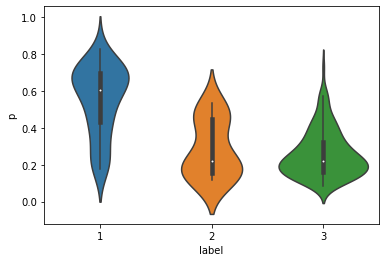

In [275]:
ax = sns.violinplot(x="label", y="p", data=dd)

In [276]:
dd.groupby('label').mean()

,lb_p,lb_u,lb_a,p,u,a
label,,,,,,
1,True,False,False,0.552541,0.0,0.447459
2,False,True,False,0.283520,0.0,0.716480
3,False,False,True,0.259756,0.0,0.740244


In [277]:
murmur_scores, outcome_scores = evaluate_model(test_folder, output_folder)
classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
    + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string

if len(sys.argv) == 3:
    print(output_string)
elif len(sys.argv) == 4:
    with open(sys.argv[3], 'w') as f:
        f.write(output_string)

#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.538,0.827,0.706,20062.573

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.685,0.686,0.643,13179.469

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.722,0.000,0.892
Accuracy,0.684,0.000,0.950

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.713,0.713
AUPRC,0.760,0.641
F-measure,0.670,0.700
Accuracy,0.622,0.753



### Threshold 변경해가며 결과 탐색

In [278]:
test_folder

'/home/ubuntu/data/hmd/murmur/test'

In [279]:
label_folder = test_folder
murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Abnormal', 'Normal']

# Load and parse label and model output files.
label_files, output_files = find_challenge_files(label_folder, output_folder)
murmur_labels = load_murmurs(label_files, murmur_classes)
murmur_binary_outputs, murmur_scalar_outputs = load_classifier_outputs(output_files, murmur_classes)
outcome_labels = load_outcomes(label_files, outcome_classes)
outcome_binary_outputs, outcome_scalar_outputs = load_classifier_outputs(output_files, outcome_classes)


print(np.mean(murmur_scalar_outputs[:,0]))
print(np.mean(murmur_scalar_outputs[:,2]))
print(np.mean(outcome_scalar_outputs[:,0]))
print(np.mean(outcome_scalar_outputs[:,1]))

0.31974839032944585
0.6802516133373321
0.4872625676905297
0.5127374331676523


In [280]:
## threshold 바꿔가면서 결과 출력

for th1 in [0.01, 0.05, 0.1, 0.15,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8] :
    murmur_binary_outputs[:,0] = murmur_scalar_outputs[:,0] > th1
    murmur_binary_outputs[:,2] = murmur_scalar_outputs[:,2] > 1 - th1
    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > th1
    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > 1 - th1
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
                + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string
    print("threshold: ", th1)
    print(output_string)
    print("-------------")


threshold:  0.01
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.713,0.713
AUPRC,0.760,0.641
F-measure,0.678,0.000
Accuracy,1.000,0.000

-------------
threshold:  0.05
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AU

### unknown  class 살려보기

In [281]:
dd.groupby('label').mean()

,lb_p,lb_u,lb_a,p,u,a
label,,,,,,
1,True,False,False,0.552541,0.0,0.447459
2,False,True,False,0.283520,0.0,0.716480
3,False,False,True,0.259756,0.0,0.740244


In [282]:

    murmur_binary_outputs[:,0] = murmur_scalar_outputs[:,0] >= .4
    murmur_binary_outputs[:,1] = (murmur_scalar_outputs[:,0] >= .4) & (murmur_scalar_outputs[:,0] < .4)
    murmur_binary_outputs[:,2] = murmur_scalar_outputs[:,0] < .4 
    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > .4
    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > .4
    
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
                + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string
#    print("threshold: ", th1)
    print(output_string)
    print("-------------")


#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.500,0.775,0.722,17155.250

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.621,0.634,0.743,11127.258

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.638,0.000,0.861
Accuracy,0.789,0.000,0.849

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.713,0.713
AUPRC,0.760,0.641
F-measure,0.690,0.551
Accuracy,0.796,0.462

-------------


In [283]:
def pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, p1 = .4, p2 = .4) :
    murmur_binary_outputs[:,0] = (murmur_scalar_outputs[:,0] >= p1)
    murmur_binary_outputs[:,1] = (murmur_scalar_outputs[:,0] >= p2) & (murmur_scalar_outputs[:,0] < p1)
    murmur_binary_outputs[:,2] = (murmur_scalar_outputs[:,0] < p2)
#    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > .4
#    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > .4
    
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
#    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
#    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
#    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
#    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
#    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
#    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
#    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
#    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
#                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

#    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
#    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
#    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
#    ','.join(classes),
#    ','.join('{:.3f}'.format(x) for x in auroc_classes),
#    ','.join('{:.3f}'.format(x) for x in auprc_classes),
#    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
#    ','.join('{:.3f}'.format(x) for x in accuracy_classes))
#+ '\n#Outcome scores\n' + outcome_output_string \
                
    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Murmur scores (per class)\n' + murmur_class_output_string #+ '\n#Outcome scores (per class)\n' + outcome_class_output_string
    print("threshold: ", p1,p2)
    print(output_string)
    print("-------------")


In [284]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels)

threshold:  0.4 0.4
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.500,0.775,0.722,17155.250

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.638,0.000,0.861
Accuracy,0.789,0.000,0.849

-------------


In [285]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .41, .41)

threshold:  0.41 0.41
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.509,0.791,0.720,17562.848

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.652,0.000,0.875
Accuracy,0.763,0.000,0.878

-------------


In [286]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .41, .35)

threshold:  0.41 0.35
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.495,0.728,0.687,15730.193

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.652,0.000,0.833
Accuracy,0.763,0.000,0.791

-------------


In [287]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .45, .35)

threshold:  0.45 0.35
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.512,0.717,0.655,15730.193

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.650,0.053,0.833
Accuracy,0.684,0.071,0.791

-------------


In [288]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .2, .2)

threshold:  0.2 0.2
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.320,0.466,0.628,11881.160

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.429,0.000,0.530
Accuracy,0.947,0.000,0.381

-------------


In [289]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .21, .21)

threshold:  0.21 0.21
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.346,0.508,0.650,11992.349

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.453,0.000,0.584
Accuracy,0.947,0.000,0.439

-------------


In [290]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .21, .2)

threshold:  0.21 0.2
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.357,0.471,0.636,11881.160

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.453,0.087,0.530
Accuracy,0.947,0.071,0.381

-------------


In [291]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .21, .21)

threshold:  0.21 0.21
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.346,0.508,0.650,11992.349

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.453,0.000,0.584
Accuracy,0.947,0.000,0.439

-------------


In [292]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .45, .32)

threshold:  0.45 0.32
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.497,0.675,0.633,14740.422

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.650,0.043,0.797
Accuracy,0.684,0.071,0.734

-------------


In [293]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .4, .4)

threshold:  0.4 0.4
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.500,0.775,0.722,17155.250

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.638,0.000,0.861
Accuracy,0.789,0.000,0.849

-------------


In [294]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .41, .39)

threshold:  0.41 0.39
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.503,0.764,0.706,16948.706

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.652,0.000,0.857
Accuracy,0.763,0.000,0.842

-------------


In [295]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .39, .39)

threshold:  0.39 0.39
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.496,0.770,0.720,16948.706

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.632,0.000,0.857
Accuracy,0.789,0.000,0.842

-------------


In [296]:
pr(murmur_binary_outputs, murmur_scalar_outputs, murmur_labels, .4, .3)

threshold:  0.4 0.3
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.470,0.665,0.666,14162.596

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.638,0.000,0.773
Accuracy,0.789,0.000,0.698

-------------


In [297]:
murmur_binary_outputs[:,0].shape

(191,)

In [298]:
(murmur_scalar_outputs[:,0] >= .3).shape

(191,)

In [299]:
## threshold 바꿔가면서 결과 출력

for th1 in [0.01, 0.05, 0.1, 0.15,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8] :
    murmur_binary_outputs[:,0] = murmur_scalar_outputs[:,0] > th1
    murmur_binary_outputs[:,2] = murmur_scalar_outputs[:,2] > 1 - th1
    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > th1
    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > 1 - th1
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
                + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string
    print("threshold: ", th1)
    print(output_string)
    print("-------------")


threshold:  0.01
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.713,0.713
AUPRC,0.760,0.641
F-measure,0.678,0.000
Accuracy,1.000,0.000

-------------
threshold:  0.05
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AU

threshold:  0.8
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.722,0.571,0.299,0.733,0.388,25482.058

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.713,0.701,0.402,0.524,0.220,24235.744

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.880,0.500,0.785
AUPRC,0.763,0.073,0.878
F-measure,0.051,0.000,0.845
Accuracy,0.026,0.000,1.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.713,0.713
AUPRC,0.760,0.641
F-measure,0.133,0.671
Accuracy,0.071,1.000

-------------
